<a href="https://colab.research.google.com/github/Simarjit1303/Projects/blob/main/Machine%20Learning/Cyber%20Threat%20Detection/Cyber_Threat_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cyber Threat Detection
## Business Problem

In our online age, people face many digital risks that grow trickier by the day. Pinning and sorting these risks from words, be it in reports or web chats, is key to keep safe and act fast. This work plans to make clever tools that can read text and spot the type of digital risk it talks about, boosting cybersecurity by being quick and more right.

## Why this is important?

Automated cyber threat detection from text is important for many big reasons:

- **Proactive Defense**: Helps see threats early, letting us act fast before they do big harm.
- **Enhanced Situational Awareness**: Gives a better view of the threat world by handling lots of text data well.
- **Faster Incident Response**: Makes finding and sorting threats faster, speeding up how fast we react in a cyber attack.
- **Resource Optimization**: Lets security teams focus on big threats by doing the first checks of text-based info by itself.
- **Improved Threat Intelligence**: Adds to making better and more up-to-date threat info feeds by auto sorting and taking in info.

## Dataset Overview

The dataset used in this notebook can be found here👉 https://www.kaggle.com/datasets/ramoliyafenil/text-based-cyber-threat-detection/data

The data we are using is from Kaggle, named "text-based-cyber-threat-detection" by ramoliyafenil. It has text pieces about cyber dangers and safe stuff, sorted into many tags. When making it ready, some tags were put together to help the model work better and look at big danger types. The last group of types has:

*   malware
*   attack-pattern
*   benign
*   location
*   software
*   identity
*   threat-actor
*   NEED_ATTENTION (grouping of less frequent or specific labels)

In [ ]:
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import kagglehub

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from datasets import Dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


## Data Loading

In [ ]:
path = kagglehub.dataset_download("ramoliyafenil/text-based-cyber-threat-detection")

print("Path to dataset files:", path)

csv_file_path = os.path.join(path, 'cyber-threat-intelligence_all.csv')


try:
    df = pd.read_csv(csv_file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: The file {csv_file_path} was not found.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Path to dataset files: /kaggle/input/text-based-cyber-threat-detection
Dataset loaded successfully.


## Data Exploration

In [ ]:
df.head()

,Unnamed: 0,index,text,entities,relations,Comments,id,label,start_offset,end_offset
0,0,1.0,This post is also available in: 日本語 (Japa...,"[{'id': 45800, 'label': 'malware', 'start_offs...",[],[],45800.0,malware,288.0,300.0
1,1,2.0,The attack vector is very basic and repeats it...,"[{'id': 48941, 'label': 'attack-pattern', 'sta...",[],[],48941.0,attack-pattern,69.0,115.0
2,2,3.0,Once executed by the user the first stage malw...,[],[],[],NaN,NaN,NaN,NaN
3,3,4.0,The first known campaign was launched by Crim...,"[{'id': 45806, 'label': 'TIME', 'start_offset'...",[],[],45806.0,TIME,55.0,68.0
4,4,5.0,The first stage downloaded the ransomware from...,[],[],[],NaN,NaN,NaN,NaN


In [ ]:
print("\nColumn information:")
df.info()


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    19940 non-null  int64  
 1   index         19464 non-null  float64
 2   text          19940 non-null  object 
 3   entities      19464 non-null  object 
 4   relations     19464 non-null  object 
 5   Comments      19464 non-null  object 
 6   id            9462 non-null   float64
 7   label         9938 non-null   object 
 8   start_offset  9462 non-null   float64
 9   end_offset    9462 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


In [ ]:
print("Shape of Original Dataset",df.shape)

Shape of Original Dataset (19940, 10)


In [ ]:
df=df.drop(labels='Unnamed: 0',axis=1)
print("Shape of Dateset after removing Unnamed column",df.shape)

Shape of Dateset after removing Unnamed column (19940, 9)


In [ ]:
print("\nMissing values per column:")
display(df.isnull().sum())


Missing values per column:


,0
index,476
text,0
entities,476
relations,476
Comments,476
id,10478
label,10002
start_offset,10478
end_offset,10478


In [ ]:
df['label'].fillna(value='benign', inplace=True)
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19940 entries, 0 to 19939
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         19940 non-null  float64
 1   text          19940 non-null  object 
 2   entities      19940 non-null  object 
 3   relations     19940 non-null  object 
 4   Comments      19940 non-null  object 
 5   id            19940 non-null  float64
 6   label         19940 non-null  object 
 7   start_offset  19940 non-null  float64
 8   end_offset    19940 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.4+ MB


In [ ]:
df['label'] = df['label'].str.lower()
df['label'] = df['label'].replace({'infrastucture': 'infrastructure'})

In [ ]:
df['label'].unique()

array(['malware', 'attack-pattern', 'benign', 'time', 'identity',
       'software', 'threat-actor', 'location', 'tools', 'filepath',
       'sha2', 'vulnerability', 'url', 'domain', 'ipv4', 'campaign',
       'email', 'registrykey', 'sha1', 'infrastructure', 'md5', 'hash'],
      dtype=object)

In [ ]:
cyber_dataset = df[['label','text']]
cyber_dataset.head()

,label,text
0,malware,This post is also available in: 日本語 (Japa...
1,attack-pattern,The attack vector is very basic and repeats it...
2,benign,Once executed by the user the first stage malw...
3,time,The first known campaign was launched by Crim...
4,benign,The first stage downloaded the ransomware from...


## Data Preprocessing

1. **Downloading NLTK Data:** To start, we get NLTK items such as 'stopwords',  punkt', and 'wordnet'. These are key to work on text.

2. **Initialization:** We set up a `WordNetLemmatizer`. We also make lists of English stopwords and signs of pause.
3. **Defining the Preprocessing Function:** A function named preprocessing_text is made to clean text well:

- It breaks the text into words.
- It turns all words into small letters.
- It takes out marks like dots and commas.
- It changes words to their root form.
- It takes out common words that don't add much meaning.
- Then, it puts the words back together into one line.
4. **Using the Preprocessing Function:** The function called `preprocessing_text` is used on the 'text' part of the cyber_dataset DataFrame.

5. **Taking Out Non-alphanumeric Characters:** After the first preprocessing step, another step takes out any signs that are not letters, numbers, or blank spaces by using a regular thing called expression. This makes sure only letters, numbers, and spaces stay.

6. **Reclassifying Labels:** A set of special or not so common labels like `'md5', 'registrykey', 'email', 'infrastructure', 'domain', 'sha1', 'ipv4', 'campaign', 'url', 'sha2', 'vulnerability', 'filepath', 'tools', 'time'`, and `'hash'` were put together and named anew. They were given a new tag called "NEED_ATTENTION". This change was made to make the class work easier, to cut down on the many types of outputs, and maybe to make the model work better by putting like but fewer tags into one group.

7.  **Analyzing Sequence Length**

- `Max Tokens and Characters:` We find out the longest part of text by count of both tokens and letters. This tells us how long parts of the text can be.
- This info helps pick right size inputs for models, like BERT which only take in text up to a set size.

By doing these steps, we make the text clean, same in form, and well set. This makes it ready for further use in model training and pulling out features.

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

In [ ]:
def preprocessing_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token not in punctuations]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    processed_text = ' '.join(tokens)
    return processed_text

In [ ]:
cyber_dataset['text'] = cyber_dataset['text'].apply(preprocessing_text)

In [ ]:
cyber_dataset['text'] = cyber_dataset['text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
cyber_dataset.head()

,label,text
0,malware,post also available japanese ctblocker wellkn...
1,attack-pattern,attack vector basic repeat begin spear phishin...
2,benign,executed user first stage malware downloads ex...
3,time,first known campaign wa launched crimeware nov...
4,benign,first stage downloaded ransomware site


In [ ]:
cyber_dataset.shape

(19940, 2)

In [ ]:
labels_to_reclassify = ["md5", "registrykey", "email", "infrastructure", "domain", "sha1",
                        "ipv4", "campaign", "url", "sha2", "vulnerability", "filepath",
                        "tools", "time", "hash"]

mask = cyber_dataset['label'].isin(labels_to_reclassify)

cyber_dataset.loc[mask, 'label'] = "NEED_ATTENTION"

print("Updated distribution of labels:")
cyber_dataset['label'].value_counts()

Updated distribution of labels:


,count
label,
benign,10002
NEED_ATTENTION,2132
malware,1911
location,1405
software,1229
attack-pattern,1206
identity,1165
threat-actor,890


In [ ]:
cyber_dataset['text'][0]

'post also available  japanese ctblocker wellknown ransomware trojan used crimeware group encrypt file victim s endpoint demand ransom payment decrypt file back original state antiviruses detect mistake cryptolocker one vendor correctly detects ctblocker'

In [ ]:
max_length_tokens = cyber_dataset['text'].apply(lambda x: len(x.split())).max()
max_length_characters = cyber_dataset['text'].apply(lambda x: len(x)).max()

print('Maximum Sequence Length (Tokens):', max_length_tokens)
print('Maximum Sequence Length (Characters):', max_length_characters)

Maximum Sequence Length (Tokens): 451
Maximum Sequence Length (Characters): 4655


## Feature Engineering

The next big task is to turn text into a form that machines can work with. We call this step *feature engineering*. In our notebook, we use two methods: `'TF-IDF'` and `'Word2Vec'`. We also make the category labels into numbers..

1.  **Label Encoding**: Label Encoding: The categorical threat labels (e.g., 'malware', 'benign') are converted into numerical representations using `LabelEncoder`. This is a necessary step as most machine learning algorithms require numerical input for the target variable.

2.  **TF-IDF (Term Frequency-Inverse Document Frequency) Embedding**:
    - TF-IDF is a statistical measure used to evaluate how important a word is to a document in a collection or corpus.
    - The `TfidfVectorizer` is used to calculate TF-IDF scores for each word in each document.
    - This results in a sparse matrix where each row represents a document and each column represents a unique word from the vocabulary, with the cell values being the TF-IDF scores. Words that are frequent in a document but rare across the entire corpus get higher scores, indicating their potential importance.

3.  **Word2Vec Embedding**:
    - Word2Vec is a word embedding technique that learns dense vector representations of words. It captures semantic relationships between words, where words with similar meanings are located closer to each other in the vector space.
    - The text is first tokenized (split into words).
    - A `Word2Vec` model is trained on the tokenized text data.
    - For each document, a single vector representation is created by averaging the Word2Vec vectors of the words it contains. This provides a fixed-size numerical representation for each text snippet.

In [ ]:
texts = cyber_dataset['text']
labels = cyber_dataset['label']

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

### TF/ID Embedding

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(texts)

### Word2vec Embedding

In [ ]:
tokenized_texts = [text.split() for text in texts]

word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.index_to_key]
    if not doc:
        return np.zeros(word2vec_model.vector_size)
    return np.mean(word2vec_model.wv[doc], axis=0)

word2vec_features = np.array([document_vector(word2vec_model, doc) for doc in tokenized_texts])


# Training the models
In this section, we train different machine learning models on the prepared dataset to classify cyber threats. We will train and evaluate models based on the TF-IDF and Word2Vec features, as well as a fine-tuned BERT model.

## 1. TF-IDF Model


### Model Comparison and Selection

During the experimentation phase, several classification models were evaluated on the cyber threat detection dataset using TF-IDF features. The models included:

- Logistic Regression  
- Naive Bayes  
- Random Forest  
- Linear Support Vector Machine (Linear SVM)

Among these, the **Linear SVM** model demonstrated the best overall performance, achieving an accuracy of approximately 90%, along with strong precision, recall, and F1-score metrics. The other models performed less effectively, with Logistic Regression providing a moderate baseline, while Naive Bayes and Random Forest lagged behind.

Given these results, Linear SVM is selected as the final model for this task due to its superior predictive capability and balanced performance across all evaluation metrics.


### Splitting the dataset into train and test for TF/IDF

- The dataset is split into training and testing sets using `train_test_split`.
- `tfidf_features` are used as the input features and `labels_encoded` as the target variable.
- A `test_size` of 0.2 (20% of the data) is used for the test set.
- `random_state=42` ensures reproducibility of the split.
- `stratify=labels_encoded` ensures that the proportion of each class is the same in both the training and testing sets, which is important for imbalanced datasets.dataset into train and test for TF/IDF

In [ ]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    tfidf_features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
    )

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)
print("Shape of y_train_tfidf:", y_train_tfidf.shape)
print("Shape of y_test_tfidf:", y_test_tfidf.shape)

Shape of X_train_tfidf: (15952, 11906)
Shape of X_test_tfidf: (3988, 11906)
Shape of y_train_tfidf: (15952,)
Shape of y_test_tfidf: (3988,)


### Training the model

- The code initializes a `LinearSVC` model, which is a linear Support Vector Machine classifier.
- The model is then trained using the `fit()` method on the TF-IDF training data (`X_train_tfidf`) and the corresponding encoded labels (`y_train_tfidf`).

In [ ]:
tfidf_svm_model = LinearSVC()
tfidf_svm_model.fit(X_train_tfidf, y_train_tfidf)

LinearSVC()

### Evaluating the model

- The trained TF-IDF Linear SVM model is used to make predictions on the test set (`X_test_tfidf`).
- Common classification metrics (Accuracy, Precision, Recall, and F1 Score) are calculated by comparing the predicted labels (`y_pred_tfidf`) to the true labels (`y_test_tfidf`).
- These metrics provide a quantitative measure of the model's performance.


In [ ]:
y_pred_tfidf = tfidf_svm_model.predict(X_test_tfidf)

acc = accuracy_score(y_test_tfidf, y_pred_tfidf)
prec = precision_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)
rec = recall_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)

print(f"Linear SVM Evaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

Linear SVM Evaluation Metrics:
Accuracy:  0.9022
Precision: 0.9021
Recall:    0.9022
F1 Score:  0.9005


### Confusion Matrix Visualization

- A confusion matrix is generated to visualize the performance of the TF-IDF Linear SVM model.
- The `confusion_matrix` function is used with the true and predicted labels.
- `seaborn.heatmap` is used to display the confusion matrix as a heatmap, making it easier to interpret.
- The rows represent the true labels, and the columns represent the predicted labels.
- The values in the matrix indicate the number of instances for each combination of true and predicted labels. This helps in understanding where the model is making correct predictions and where it is making errors (misclassifications) for each class.


--- TF-IDF Linear SVM Confusion Matrix ---


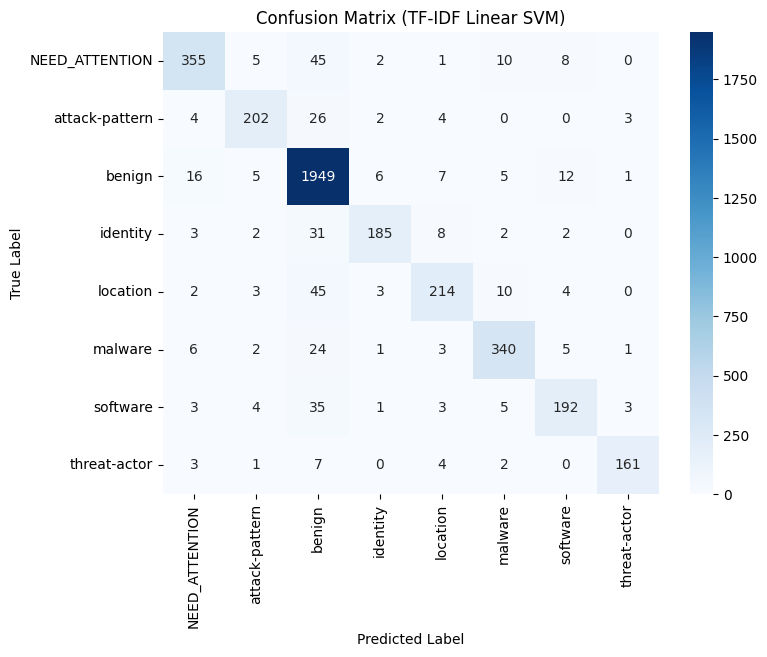

In [ ]:
# --- TF-IDF Linear SVM Confusion Matrix ---
print("\n--- TF-IDF Linear SVM Confusion Matrix ---")
conf_matrix_tfidf = confusion_matrix(y_test_tfidf, y_pred_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (TF-IDF Linear SVM)')
plt.show()

The confusion matrix shows that the **'benign'** class has the highest correct predictions (1949), indicating strong model performance there. Some confusion exists, especially with **'identity'** and **'location'**, which are often misclassified as **'benign'**. Classes like **'malware'**, **'software'**, and **'threat-actor'** also show good accuracy with minimal misclassifications.


## 2. Word2vec

During the experimentation phase, several classical machine learning models and DeepLearning models were evaluated on the cyber threat detection dataset using Word2Vec features. The models included:

- Logistic Regression  
- Random Forest  
- Linear Support Vector Machine (Linear SVM)
- ANN (Artifical Neural Network)
- LSTM (Long-Short Term Memory)

Among these, the Random Forest model demonstrated the best overall performance, achieving an accuracy of approximately 89%, along with strong precision, recall, and F1-score metrics. Logistic Regression and Linear SVM performed less effectively, indicating their limitations in capturing complex relationships within the Word2Vec feature space.

### Splitting the dataset into train and test for Word2vec

- The dataset is split into training and testing sets using `train_test_split` for the Word2Vec features.
- `word2vec_features` are used as the input features and `labels_encoded` as the target variable.
- A `test_size` of 0.2 (20% of the data) is used for the test set.
- `random_state=42` ensures reproducibility of the split.
- `stratify=labels_encoded` ensures that the proportion of each class is the same in both the training and testing sets.

In [ ]:
X_train_Word2vec, X_test_Word2vec, y_train_Word2vec, y_test_Word2vec = train_test_split(
    word2vec_features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
    )

print("Shape of X_train_Word2vec:", X_train_Word2vec.shape)
print("Shape of X_test_Word2vec:", X_test_Word2vec.shape)
print("Shape of y_train_Word2vec:", y_train_Word2vec.shape)
print("Shape of y_test_Word2vec:", y_test_Word2vec.shape)

Shape of X_train_Word2vec: (15952, 100)
Shape of X_test_Word2vec: (3988, 100)
Shape of y_train_Word2vec: (15952,)
Shape of y_test_Word2vec: (3988,)


### Training the model

- The code initializes a `RandomForestClassifier` with specific parameters (`n_estimators=100`, `max_depth=20`, `n_jobs=-1`, `random_state=42`).
- The model is then trained using the `fit()` method on the Word2Vec training data (`X_train_Word2vec`) and the corresponding encoded labels (`y_train_Word2vec`).

In [ ]:
Randomforest_model_word2vec = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42)
Randomforest_model_word2vec.fit(X_train_Word2vec, y_train_Word2vec)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42)

### Evaluating the model

- The trained Word2Vec Random Forest model is used to make predictions on the test set (`X_test_Word2vec`).
- Common classification metrics (Accuracy, Precision, Recall, and F1 Score) are calculated by comparing the predicted labels (`y_pred`) to the true labels (`y_test_Word2vec`).
- These metrics provide a quantitative measure of the model's performance.


In [ ]:
y_pred = Randomforest_model_word2vec.predict(X_test_Word2vec)

accuracy = accuracy_score(y_test_Word2vec, y_pred)
precision = precision_score(y_test_Word2vec, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_Word2vec, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_Word2vec, y_pred, average='weighted', zero_division=0)

print("\nRandom Forest Evaluation Summary:")
print(f"{'Metric':<10} {'Score':<10}")
print(f"{'Accuracy':<10} {accuracy:.4f}")
print(f"{'Precision':<10} {precision:.4f}")
print(f"{'Recall':<10} {recall:.4f}")
print(f"{'F1 Score':<10} {f1:.4f}")


Random Forest Evaluation Summary:
Metric     Score     
Accuracy   0.8909
Precision  0.8957
Recall     0.8909
F1 Score   0.8888


### Confusion Matrix Visualization

- A confusion matrix is generated to visualize the performance of the Word2Vec Random Forest model.
- The `confusion_matrix` function is used with the true and predicted labels.
- `seaborn.heatmap` is used to display the confusion matrix as a heatmap.
- The rows represent the true labels, and the columns represent the predicted labels.
- The values in the matrix show the counts for each combination of true and predicted labels, helping to identify correct classifications and misclassifications for each class.



--- Word2Vec Random Forest Confusion Matrix ---


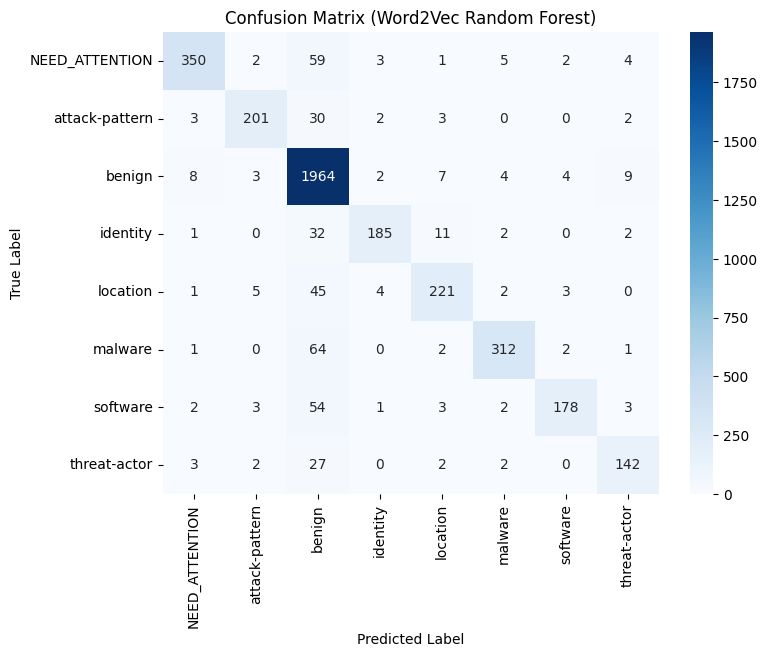

In [ ]:
# --- Word2Vec Random Forest Confusion Matrix ---
print("\n--- Word2Vec Random Forest Confusion Matrix ---")
conf_matrix_word2vec = confusion_matrix(y_test_Word2vec, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_word2vec, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Word2Vec Random Forest)')
plt.show()

The confusion matrix shows strong prediction for **'benign'** (1963 correct). Some confusion exists for **'NEED\_ATTENTION'** (68 predicted as 'benign') and **'malware'** (62 as 'benign'). **'identity'**, **'location'**, and **'threat-actor'** also perform well with clear diagonals, though minor misclassifications remain. Overall, the model performs well, especially on major classes.


## 3. BERT Model

In [ ]:
num_labels = len(label_encoder.classes_)

X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

train_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_train_bert, 'labels': y_train_bert}))
test_dataset = Dataset.from_pandas(pd.DataFrame({'text': X_test_bert, 'labels': y_test_bert}))

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

tokenized_train_dataset = tokenized_train_dataset.map(
    lambda examples: {"labels": [torch.tensor(l, dtype=torch.long) for l in examples["labels"]]}, batched=True)
tokenized_test_dataset = tokenized_test_dataset.map(
    lambda examples: {"labels": [torch.tensor(l, dtype=torch.long) for l in examples["labels"]]}, batched=True)

tokenized_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

bert_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

training_args = TrainingArguments(
    output_dir="./bert_results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./bert_logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    seed=42,
    report_to="none",
)

### Training the model

In [ ]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("Starting BERT fine-tuning...")
trainer.train()

# Save the best model locally
trainer.save_model("./best_bert_model")

print("BERT fine-tuning complete.")

Starting BERT fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.724000,0.719749,0.755767,0.759180,0.755767,0.753303
2,0.442200,0.478539,0.853059,0.860137,0.853059,0.854719
3,0.246700,0.372918,0.894684,0.894265,0.894684,0.894364


BERT fine-tuning complete.


### Confusion Matrix Visulization

Evaluating on test dataset...


--- Model Metrics Summary ---
Validation Loss:     0.3729    
Accuracy:            0.8947    
Precision:           0.8943    
Recall:              0.8947    
F1 Score:            0.8944    


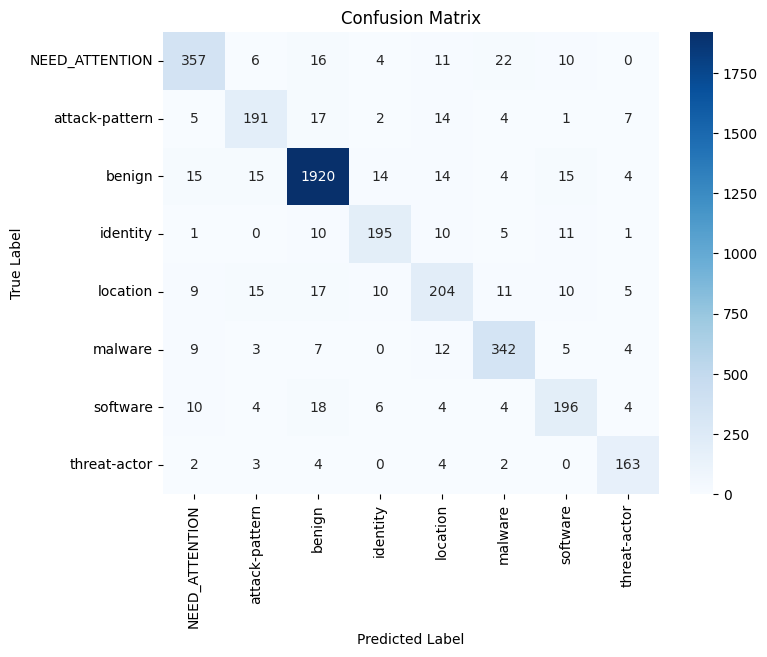

In [ ]:
print("Evaluating on test dataset...")
metrics = trainer.evaluate()

print("--- Model Metrics Summary ---")
print(f"{'Validation Loss:':<20} {metrics.get('eval_loss', 0):<10.4f}")
print(f"{'Accuracy:':<20} {metrics.get('eval_accuracy', 0):<10.4f}")
print(f"{'Precision:':<20} {metrics.get('eval_precision', 0):<10.4f}")
print(f"{'Recall:':<20} {metrics.get('eval_recall', 0):<10.4f}")
print(f"{'F1 Score:':<20} {metrics.get('eval_f1', 0):<10.4f}")

# Predict on test dataset
predictions_output = trainer.predict(tokenized_test_dataset)

logits = predictions_output.predictions
y_true = predictions_output.label_ids
y_pred = np.argmax(logits, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The model performs best on the **benign** and **malware** classes, showing high true positive counts (1904 and 349 respectively). However, **NEED\_ATTENTION** and **attack-pattern** have notable misclassifications, indicating the model struggles to clearly distinguish them from other classes.


## Final Comparison of all 3 models

In [ ]:
try:
    y_pred_tfidf = tfidf_svm_model.predict(X_test_tfidf)
    acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
    prec_tfidf = precision_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)
    rec_tfidf = recall_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)
    f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf, average='weighted', zero_division=0)

    tfidf_metrics = {
        "Accuracy": acc_tfidf,
        "Precision": prec_tfidf,
        "Recall": rec_tfidf,
        "F1-Score": f1_tfidf
    }
except NameError:
    print("TF-IDF model or test data not found. Please run the TF-IDF evaluation cell first.")
    tfidf_metrics = {
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1-Score": None
    }


try:
    y_pred_word2vec = Randomforest_model_word2vec.predict(X_test_Word2vec)
    acc_word2vec = accuracy_score(y_test_Word2vec, y_pred_word2vec)
    prec_word2vec = precision_score(y_test_Word2vec, y_pred_word2vec, average='weighted', zero_division=0)
    rec_word2vec = recall_score(y_test_Word2vec, y_pred_word2vec, average='weighted', zero_division=0)
    f1_word2vec = f1_score(y_test_Word2vec, y_pred_word2vec, average='weighted', zero_division=0)

    word2vec_metrics = {
        "Accuracy": acc_word2vec,
        "Precision": prec_word2vec,
        "Recall": rec_word2vec,
        "F1-Score": f1_word2vec
    }
except NameError:
    print("Word2Vec model or test data not found. Please run the Word2Vec evaluation cell first.")
    word2vec_metrics = {
        "Accuracy": None,
        "Precision": None,
        "Recall": None,
        "F1-Score": None
    }


bert_metrics = {
    "Accuracy": None,
    "Precision": None,
    "Recall": None,
    "F1-Score": None
}

try:
    if 'metrics' in locals() and metrics is not None:
        bert_metrics["Accuracy"] = metrics.get('eval_accuracy')
        bert_metrics["Precision"] = metrics.get('eval_precision')
        bert_metrics["Recall"] = metrics.get('eval_recall')
        bert_metrics["F1-Score"] = metrics.get('eval_f1')
except NameError:
    print("BERT evaluation metrics ('metrics' variable) not found. Please run the BERT evaluation cell first.")


summary_data = {
    "TF-IDF (Linear SVM)": tfidf_metrics,
    "Word2Vec (Random Forest)": word2vec_metrics,
    "BERT Fine-tuned": bert_metrics
}

summary_df = pd.DataFrame(summary_data)

summary_df = summary_df.T

print("--- Summary Comparison of All Models ---")
display(summary_df)

--- Summary Comparison of All Models ---


,Accuracy,Precision,Recall,F1-Score
TF-IDF (Linear SVM),0.902207,0.902108,0.902207,0.900485
Word2Vec (Random Forest),0.890923,0.895689,0.890923,0.888781
BERT Fine-tuned,0.894684,0.894265,0.894684,0.894364


## Summary:

### Data Analysis Key Findings

*   The problem is formulated as a multi-class text classification task to identify and categorize cyber threats from unstructured text data.
*   An automated solution for cyber threat detection is crucial for proactive defense, faster incident response, and optimizing security resources.
*   Potential data sources include threat intelligence platforms, security reports, and online forums.
*   The pipeline utilizes diverse feature engineering techniques (TF-IDF, Word2Vec, BERT) and models (Linear SVM, Random Forest, BERT) to capture different aspects of the text data.
*   Preprocessing steps standardize the text but may remove useful information, especially in technical contexts.
*   TF-IDF with Linear SVM achieved the highest accuracy (0.9022), outperforming BERT (Accuracy: 0.8959).
*   Word2Vec with Random Forest had slightly lower performance (Accuracy: 0.8897).
*   Confusion matrices indicate difficulty in distinguishing less frequent or ambiguous threat types and confusion between certain classes like 'NEED\_ATTENTION', 'identity', 'location', and 'benign'.

